In [1]:
import torch
import torchvision
from torchvision import datasets
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
import os
from torch.optim import SGD
from torch.nn import functional as F
import random
import numpy as np
from tqdm import tqdm_notebook
from matplotlib import pyplot as plt
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [3]:
# FOR CIFAR10

class Cifar_model(nn.Module):
    def __init__(self):
        super(Cifar_model, self).__init__()
        
        self.relu = nn.ReLU()
        
        self.conv1 = nn.Conv2d(3, 8, 3, padding=2, stride=2)
        self.bn1 = nn.BatchNorm2d(8)
        
        self.conv2 = nn.Conv2d(8, 16, 3, padding=2, stride=2)
        self.bn2 = nn.BatchNorm2d(16)
        
        self.conv3 = nn.Conv2d(16, 32, 3, padding=2, stride=2)
        self.bn3 = nn.BatchNorm2d(32)
        
        self.conv4 = nn.Conv2d(32, 64, 3, padding=2, stride=2)
        self.bn4 = nn.BatchNorm2d(64)
        
        self.conv5 = nn.Conv2d(64, 128, 3, padding=2, stride=2)
        self.bn5 = nn.BatchNorm2d(128)
        
        self.conv6 = nn.Conv2d(128, 256, 3, padding=2, stride=2)
        self.bn6 = nn.BatchNorm2d(256)
        
        self.conv7 = nn.Conv2d(256, 10, 3)
        
        self.flatten = Flatten()
        
        
    def forward(self, x):

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu(x)
        
        x = self.conv5(x)
        x = self.bn5(x)
        x = self.relu(x)
        
        x = self.conv6(x)
        x = self.bn6(x)
        x = self.relu(x)
        
        x = self.conv7(x)
        
        x = self.flatten(x)
        
        return x

In [4]:
# FOR MNIST

class Mnist_model(nn.Module):
    def __init__(self):
        super(Mnist_model, self).__init__()
        
        self.relu = nn.ReLU()
        
        self.conv1 = nn.Conv2d(1, 8, 3, padding=2, stride=2)
        self.bn1 = nn.BatchNorm2d(8)
        
        self.conv2 = nn.Conv2d(8, 16, 3, padding=2, stride=2)
        self.bn2 = nn.BatchNorm2d(16)
        
        self.conv3 = nn.Conv2d(16, 32, 3, padding=2, stride=2)
        self.bn3 = nn.BatchNorm2d(32)
        
        self.conv4 = nn.Conv2d(32, 64, 3, padding=2, stride=2)
        self.bn4 = nn.BatchNorm2d(64)
        
        self.conv5 = nn.Conv2d(64, 128, 3, padding=2, stride=2)
        self.bn5 = nn.BatchNorm2d(128)
        
        self.conv6 = nn.Conv2d(128, 10, 3)
        
        self.flatten = Flatten()
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu(x)
        
        x = self.conv5(x)
        x = self.bn5(x)
        x = self.relu(x)
        
        x = self.conv6(x)
        
        x = self.flatten(x)
        
        return x

In [5]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                          torchvision.transforms.Normalize((0.1307,), (0.3081,))])

# mnist_data = datasets.MNIST("MNIST/", download=True, transform=transform)
# mnist_data_test = datasets.MNIST("MNIST/", download=True, train=False, transform=transform)

cifar_data = datasets.CIFAR10("CIFAR10/", download=True, transform=transform)
cifar_data_test = datasets.CIFAR10("CIFAR10/", download=True, train=False, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
train_loader = DataLoader(cifar_data, 
                          batch_size=100, 
                          shuffle=True)

test_loader = DataLoader(cifar_data_test, 
                         batch_size=100)

In [74]:
lr = 1e-1
sigma = 0.1
epochs = 50

In [77]:
train_losses = [[[] for i in range(epochs)] for j in range(7)]
test_losses = [[[] for i in range(epochs)] for j in range(7)]

train_acc = [[] for j in range(7)]
test_acc = [[] for j in range(7)]

for n_experiment in range(7):
    print("Experiment #%i started" % n_experiment)
    model = Cifar_model()
    model.cuda()
    t = 0
    for n_epoch in tqdm_notebook(range(epochs)):
        # TRAINING
        
        correct = 0
        total = 0
        
        print("================================")
        print("Epoch %i started" % n_epoch)
        model.train(True)
        for n_batch, (batch_x, batch_y) in tqdm_notebook(enumerate(train_loader)):
            t += 1
            
            if ((n_experiment - 1) % 2 == 0):
                gamma_t = 1. / np.sqrt(t + 1)
            elif ((n_experiment - 1) % 2 == 1):
                gamma_t = 1. / (t + 1)

            output = model(batch_x.cuda())
            loss = F.cross_entropy(output, batch_y.cuda())
            for param in model.parameters():
                if param.grad is not None:
                    param.grad.data.zero_()

            loss.backward()
            train_losses[n_experiment][n_epoch].append(loss.cpu().detach().numpy())
            for param in model.parameters():
                weight_update = param.grad
                if ((n_experiment - 1) // 2 == 0):
                    sigma = 0.01
                elif ((n_experiment - 1) // 2 == 1):
                    sigma = 0.05
                elif ((n_experiment - 1) // 2 == 2):
                    sigma = 0.1
                rand_update = torch.FloatTensor(gamma_t * np.random.normal(0, sigma, param.shape)).cuda()
                param.data.sub_(weight_update * lr)
                if n_experiment > 0:
                    param.data.add_(rand_update)
                
            _, predicted = torch.max(output.data, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y.cuda()).sum().item()

        print("Average train loss: %.3f" % np.average(train_losses[n_experiment][n_epoch]))
        
        acc = 100.0 * correct / total
        train_acc[n_experiment].append(acc)
        
        print("Train accuracy: %.2f" % acc)

        # EVALUATING
        
        correct = 0
        total = 0
        
        model.train(False)
        for n_batch_test, (test_batch_x, test_batch_y) in tqdm_notebook(enumerate(test_loader)):
            with torch.no_grad():
                test_output = model(test_batch_x.cuda())
                test_loss = F.cross_entropy(test_output, test_batch_y.cuda())

                test_losses[n_experiment][n_epoch].append(test_loss.cpu().detach().numpy())
            
            _, predicted = torch.max(test_output.data, 1)
            total += test_batch_y.size(0)
            correct += (predicted == test_batch_y.cuda()).sum().item()

        print("Average test loss: %.3f\n" % np.average(test_losses[n_experiment][n_epoch]))
        
        acc = 100.0 * correct / total
        test_acc[n_experiment].append(acc)
        
        print("Test accuracy: %.2f" % acc)

Experiment #0 started


HBox(children=(IntProgress(value=0, max=50), HTML(value=u'')))

Epoch 0 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Exception in thread Thread-29:
Traceback (most recent call last):
  File "/usr/lib/python2.7/threading.py", line 801, in __bootstrap_inner
    self.run()
  File "/usr/local/lib/python2.7/dist-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/usr/lib/python2.7/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



Average train loss: 1.646
Train accuracy: 39.63


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.655

Test accuracy: 41.52
Epoch 1 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 1.322
Train accuracy: 51.94


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.556

Test accuracy: 46.75
Epoch 2 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 1.188
Train accuracy: 57.07


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.221

Test accuracy: 56.22
Epoch 3 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 1.098
Train accuracy: 60.57


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.192

Test accuracy: 57.78
Epoch 4 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 1.026
Train accuracy: 63.45


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.087

Test accuracy: 60.87
Epoch 5 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.966
Train accuracy: 65.56


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.075

Test accuracy: 61.92
Epoch 6 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.916
Train accuracy: 67.34


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.129

Test accuracy: 60.10
Epoch 7 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.862
Train accuracy: 69.20


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.261

Test accuracy: 58.52
Epoch 8 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.819
Train accuracy: 70.63


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.120

Test accuracy: 61.58
Epoch 9 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.769
Train accuracy: 72.65


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.196

Test accuracy: 60.38
Epoch 10 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.725
Train accuracy: 73.98


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.165

Test accuracy: 60.92
Epoch 11 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.683
Train accuracy: 75.31


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.093

Test accuracy: 63.94
Epoch 12 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.638
Train accuracy: 77.03


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.163

Test accuracy: 62.99
Epoch 13 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.592
Train accuracy: 78.83


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.164

Test accuracy: 62.57
Epoch 14 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.548
Train accuracy: 80.28


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.234

Test accuracy: 62.16
Epoch 15 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.505
Train accuracy: 82.01


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.225

Test accuracy: 62.68
Epoch 16 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.460
Train accuracy: 83.46


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.238

Test accuracy: 63.78
Epoch 17 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.428
Train accuracy: 84.43


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.334

Test accuracy: 62.11
Epoch 18 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.380
Train accuracy: 86.47


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.362

Test accuracy: 62.28
Epoch 19 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.349
Train accuracy: 87.36


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.470

Test accuracy: 62.47
Epoch 20 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.308
Train accuracy: 89.19


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.591

Test accuracy: 60.90
Epoch 21 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.280
Train accuracy: 90.00


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.560

Test accuracy: 61.74
Epoch 22 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.252
Train accuracy: 90.91


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.557

Test accuracy: 63.31
Epoch 23 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.220
Train accuracy: 92.25


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.643

Test accuracy: 62.56
Epoch 24 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.196
Train accuracy: 93.16


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.703

Test accuracy: 61.14
Epoch 25 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.174
Train accuracy: 93.96


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.729

Test accuracy: 63.04
Epoch 26 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.153
Train accuracy: 94.68


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.733

Test accuracy: 62.89
Epoch 27 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.136
Train accuracy: 95.31


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.853

Test accuracy: 63.09
Epoch 28 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.128
Train accuracy: 95.51


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.964

Test accuracy: 61.43
Epoch 29 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.117
Train accuracy: 96.02


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.933

Test accuracy: 62.63
Epoch 30 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.091
Train accuracy: 97.04


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 2.051

Test accuracy: 62.61
Epoch 31 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.089
Train accuracy: 97.06


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 2.097

Test accuracy: 62.31
Epoch 32 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.067
Train accuracy: 97.86


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 2.192

Test accuracy: 62.46
Epoch 33 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.064
Train accuracy: 97.92


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 2.164

Test accuracy: 62.49
Epoch 34 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.067
Train accuracy: 97.77


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 2.162

Test accuracy: 62.90
Epoch 35 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.052
Train accuracy: 98.41


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 2.261

Test accuracy: 63.45
Epoch 36 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.054
Train accuracy: 98.26


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 2.246

Test accuracy: 63.32
Epoch 37 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.050
Train accuracy: 98.41


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 2.277

Test accuracy: 62.21
Epoch 38 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.049
Train accuracy: 98.40


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 2.233

Test accuracy: 63.39
Epoch 39 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.041
Train accuracy: 98.75


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 2.377

Test accuracy: 62.56
Epoch 40 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.034
Train accuracy: 98.96


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 2.457

Test accuracy: 62.78
Epoch 41 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.041
Train accuracy: 98.67


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 2.361

Test accuracy: 62.82
Epoch 42 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.035
Train accuracy: 98.86


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 2.356

Test accuracy: 63.77
Epoch 43 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.027
Train accuracy: 99.15


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 2.484

Test accuracy: 62.80
Epoch 44 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.020
Train accuracy: 99.47


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 2.545

Test accuracy: 62.60
Epoch 45 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.017
Train accuracy: 99.55


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 2.583

Test accuracy: 63.10
Epoch 46 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.015
Train accuracy: 99.58


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 2.553

Test accuracy: 63.52
Epoch 47 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.008
Train accuracy: 99.87


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 2.636

Test accuracy: 63.64
Epoch 48 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.006
Train accuracy: 99.89


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 2.658

Test accuracy: 63.50
Epoch 49 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.003
Train accuracy: 99.98


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 2.658

Test accuracy: 63.54
Experiment #1 started


HBox(children=(IntProgress(value=0, max=50), HTML(value=u'')))

Epoch 0 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 1.677
Train accuracy: 39.05


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.722

Test accuracy: 40.52
Epoch 1 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 1.362
Train accuracy: 50.50


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.354

Test accuracy: 50.59
Epoch 2 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 1.245
Train accuracy: 54.88


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.260

Test accuracy: 53.95
Epoch 3 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 1.164
Train accuracy: 58.11


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.334

Test accuracy: 52.47
Epoch 4 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 1.094
Train accuracy: 60.88


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.173

Test accuracy: 57.79
Epoch 5 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 1.031
Train accuracy: 63.07


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.175

Test accuracy: 58.55
Epoch 6 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.971
Train accuracy: 65.21


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.156

Test accuracy: 58.71
Epoch 7 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.919
Train accuracy: 67.38


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.124

Test accuracy: 60.23
Epoch 8 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.865
Train accuracy: 68.95


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.191

Test accuracy: 59.25
Epoch 9 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.814
Train accuracy: 70.96


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.140

Test accuracy: 61.25
Epoch 10 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.769
Train accuracy: 72.58


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.202

Test accuracy: 59.99
Epoch 11 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.724
Train accuracy: 73.98


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.198

Test accuracy: 60.84
Epoch 12 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.675
Train accuracy: 75.84


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.164

Test accuracy: 61.17
Epoch 13 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.630
Train accuracy: 77.58


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.239

Test accuracy: 60.44
Epoch 14 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.587
Train accuracy: 78.89


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.277

Test accuracy: 60.60
Epoch 15 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.539
Train accuracy: 80.60


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.289

Test accuracy: 60.16
Epoch 16 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.502
Train accuracy: 82.15


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.343

Test accuracy: 60.39
Epoch 17 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.451
Train accuracy: 83.85


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.355

Test accuracy: 60.50
Epoch 18 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.414
Train accuracy: 85.22


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.404

Test accuracy: 60.62
Epoch 19 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.377
Train accuracy: 86.59


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.423

Test accuracy: 61.34
Epoch 20 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.339
Train accuracy: 87.98


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.587

Test accuracy: 59.64
Epoch 21 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.311
Train accuracy: 89.08


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.612

Test accuracy: 58.94
Epoch 22 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.279
Train accuracy: 90.01


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.668

Test accuracy: 59.28
Epoch 23 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.243
Train accuracy: 91.42


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.645

Test accuracy: 60.93
Epoch 24 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.217
Train accuracy: 92.44


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.816

Test accuracy: 59.88
Epoch 25 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.195
Train accuracy: 93.18


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.779

Test accuracy: 59.94
Epoch 26 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.175
Train accuracy: 93.96


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.946

Test accuracy: 58.15
Epoch 27 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.154
Train accuracy: 94.72


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 2.026

Test accuracy: 59.81
Epoch 28 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.138
Train accuracy: 95.34


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.992

Test accuracy: 60.91
Epoch 29 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.140
Train accuracy: 95.24


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 2.000

Test accuracy: 60.37
Epoch 30 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.108
Train accuracy: 96.50


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 2.109

Test accuracy: 60.33
Epoch 31 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.096
Train accuracy: 96.91


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 2.061

Test accuracy: 61.11
Epoch 32 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.081
Train accuracy: 97.39


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 2.247

Test accuracy: 59.91
Epoch 33 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.079
Train accuracy: 97.43


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 2.203

Test accuracy: 60.86
Epoch 34 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.069
Train accuracy: 97.84


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 2.287

Test accuracy: 60.86
Epoch 35 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.061
Train accuracy: 98.07


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 2.377

Test accuracy: 61.03
Epoch 36 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.065
Train accuracy: 97.93


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 2.324

Test accuracy: 60.53
Epoch 37 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.064
Train accuracy: 97.93


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 2.286

Test accuracy: 61.19
Epoch 38 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.059
Train accuracy: 98.11


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 2.299

Test accuracy: 61.08
Epoch 39 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.057
Train accuracy: 98.14


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 2.424

Test accuracy: 60.73
Epoch 40 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.043
Train accuracy: 98.66


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 2.425

Test accuracy: 61.10
Epoch 41 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.034
Train accuracy: 99.05


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 2.401

Test accuracy: 61.35
Epoch 42 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.034
Train accuracy: 99.04


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 2.456

Test accuracy: 61.27
Epoch 43 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.022
Train accuracy: 99.46


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 2.530

Test accuracy: 61.59
Epoch 44 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.018
Train accuracy: 99.57


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 2.581

Test accuracy: 61.85
Epoch 45 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.019
Train accuracy: 99.50


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 2.600

Test accuracy: 61.38
Epoch 46 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.015
Train accuracy: 99.67


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 2.609

Test accuracy: 61.94
Epoch 47 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.010
Train accuracy: 99.82


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 2.695

Test accuracy: 61.78
Epoch 48 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.006
Train accuracy: 99.91


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 2.632

Test accuracy: 62.02
Epoch 49 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.005
Train accuracy: 99.95


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 2.726

Test accuracy: 62.16

Experiment #2 started


HBox(children=(IntProgress(value=0, max=50), HTML(value=u'')))

Epoch 0 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 1.654
Train accuracy: 39.66


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.431

Test accuracy: 47.71
Epoch 1 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 1.310
Train accuracy: 52.75


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.246

Test accuracy: 54.72
Epoch 2 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 1.177
Train accuracy: 57.98


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.174

Test accuracy: 58.22
Epoch 3 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 1.083
Train accuracy: 61.33


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.146

Test accuracy: 59.07
Epoch 4 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 1.012
Train accuracy: 64.18


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.178

Test accuracy: 59.06
Epoch 5 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.947
Train accuracy: 66.26


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.118

Test accuracy: 60.54
Epoch 6 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.889
Train accuracy: 68.38


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.063

Test accuracy: 62.36
Epoch 7 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.835
Train accuracy: 70.33


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.143

Test accuracy: 59.75
Epoch 8 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.783
Train accuracy: 72.17


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.128

Test accuracy: 61.32
Epoch 9 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.734
Train accuracy: 73.73


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.075

Test accuracy: 62.88
Epoch 10 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.688
Train accuracy: 75.37


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.125

Test accuracy: 62.37
Epoch 11 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.639
Train accuracy: 77.28


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.178

Test accuracy: 62.46
Epoch 12 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.589
Train accuracy: 78.86


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.223

Test accuracy: 61.77
Epoch 13 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.544
Train accuracy: 80.54


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.292

Test accuracy: 60.50
Epoch 14 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.499
Train accuracy: 82.34


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.242

Test accuracy: 61.94
Epoch 15 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.456
Train accuracy: 83.70


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.330

Test accuracy: 61.23
Epoch 16 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.414
Train accuracy: 85.26


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.296

Test accuracy: 63.43
Epoch 17 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.365
Train accuracy: 86.83


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.396

Test accuracy: 61.62
Epoch 18 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.341
Train accuracy: 87.81


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.386

Test accuracy: 63.01
Epoch 19 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.303
Train accuracy: 89.22


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.449

Test accuracy: 63.47
Epoch 20 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.271
Train accuracy: 90.42


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.429

Test accuracy: 62.70
Epoch 21 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.241
Train accuracy: 91.41


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.550

Test accuracy: 62.72
Epoch 22 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.208
Train accuracy: 92.68


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.569

Test accuracy: 63.23
Epoch 23 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.188
Train accuracy: 93.37


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.653

Test accuracy: 62.59
Epoch 24 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.172
Train accuracy: 93.99


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.656

Test accuracy: 63.30
Epoch 25 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.148
Train accuracy: 94.90


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.768

Test accuracy: 62.20
Epoch 26 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.123
Train accuracy: 95.82


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.974

Test accuracy: 62.76
Epoch 27 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.111
Train accuracy: 96.18


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.889

Test accuracy: 62.94
Epoch 28 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.110
Train accuracy: 96.27


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.883

Test accuracy: 63.84
Epoch 29 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.091
Train accuracy: 96.95


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.936

Test accuracy: 63.04
Epoch 30 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.082
Train accuracy: 97.28


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 2.036

Test accuracy: 63.25
Epoch 31 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.074
Train accuracy: 97.53


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 2.108

Test accuracy: 63.58
Epoch 32 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.067
Train accuracy: 97.76


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 2.108

Test accuracy: 63.63
Epoch 33 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.065
Train accuracy: 97.90


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 2.198

Test accuracy: 63.08
Epoch 34 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.053
Train accuracy: 98.30


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 2.196

Test accuracy: 63.74
Epoch 35 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.048
Train accuracy: 98.48


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 2.271

Test accuracy: 62.80
Epoch 36 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.048
Train accuracy: 98.45


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 2.285

Test accuracy: 63.29
Epoch 37 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.046
Train accuracy: 98.53


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 2.270

Test accuracy: 63.20
Epoch 38 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.037
Train accuracy: 98.85


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 2.292

Test accuracy: 63.20
Epoch 39 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.026
Train accuracy: 99.25


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 2.345

Test accuracy: 63.21
Epoch 40 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.026
Train accuracy: 99.26


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 2.345

Test accuracy: 63.71
Epoch 41 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.024
Train accuracy: 99.40


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 2.435

Test accuracy: 64.09
Epoch 42 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.016
Train accuracy: 99.58


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 2.418

Test accuracy: 64.46
Epoch 43 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.009
Train accuracy: 99.83


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 2.404

Test accuracy: 64.74
Epoch 44 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.005
Train accuracy: 99.93


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 2.483

Test accuracy: 64.82
Epoch 45 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.004
Train accuracy: 99.95


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 2.490

Test accuracy: 65.06
Epoch 46 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.002
Train accuracy: 99.99


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 2.556

Test accuracy: 65.13
Epoch 47 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.002
Train accuracy: 100.00


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 2.574

Test accuracy: 65.23
Epoch 48 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.001
Train accuracy: 100.00


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 2.577

Test accuracy: 65.23
Epoch 49 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.001
Train accuracy: 100.00


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 2.596

Test accuracy: 65.29

Experiment #3 started


HBox(children=(IntProgress(value=0, max=50), HTML(value=u'')))

Epoch 0 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 2.029
Train accuracy: 29.73


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.619

Test accuracy: 41.02
Epoch 1 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 1.552
Train accuracy: 43.54


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.458

Test accuracy: 46.75
Epoch 2 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 1.419
Train accuracy: 48.58


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.430

Test accuracy: 47.59
Epoch 3 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 1.336
Train accuracy: 51.54


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.356

Test accuracy: 50.35
Epoch 4 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 1.273
Train accuracy: 54.09


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.304

Test accuracy: 52.81
Epoch 5 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 1.220
Train accuracy: 56.12


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.316

Test accuracy: 52.59
Epoch 6 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 1.170
Train accuracy: 57.92


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.240

Test accuracy: 55.81
Epoch 7 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 1.127
Train accuracy: 59.59


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.291

Test accuracy: 54.59
Epoch 8 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 1.090
Train accuracy: 61.08


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.338

Test accuracy: 53.31
Epoch 9 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 1.056
Train accuracy: 62.45


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.230

Test accuracy: 56.63
Epoch 10 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 1.021
Train accuracy: 63.51


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.268

Test accuracy: 55.65
Epoch 11 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.992
Train accuracy: 64.66


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.155

Test accuracy: 59.13
Epoch 12 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.959
Train accuracy: 66.08


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.165

Test accuracy: 58.57
Epoch 13 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.930
Train accuracy: 66.94


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.288

Test accuracy: 54.77
Epoch 14 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.908
Train accuracy: 67.69


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.138

Test accuracy: 59.66
Epoch 15 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.882
Train accuracy: 68.49


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.149

Test accuracy: 60.49
Epoch 16 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.857
Train accuracy: 69.47


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.152

Test accuracy: 59.62
Epoch 17 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.829
Train accuracy: 70.38


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.177

Test accuracy: 59.86
Epoch 18 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.803
Train accuracy: 71.31


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.124

Test accuracy: 61.50
Epoch 19 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.780
Train accuracy: 72.20


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.185

Test accuracy: 60.11
Epoch 20 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.760
Train accuracy: 72.92


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.209

Test accuracy: 59.96
Epoch 21 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.730
Train accuracy: 73.93


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.170

Test accuracy: 60.89
Epoch 22 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.708
Train accuracy: 74.88


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.336

Test accuracy: 56.92
Epoch 23 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.682
Train accuracy: 75.84


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.279

Test accuracy: 59.09
Epoch 24 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.661
Train accuracy: 76.54


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.197

Test accuracy: 61.38
Epoch 25 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.634
Train accuracy: 77.55


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.236

Test accuracy: 60.93
Epoch 26 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.609
Train accuracy: 78.38


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.218

Test accuracy: 61.78
Epoch 27 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.591
Train accuracy: 78.97


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.265

Test accuracy: 61.50
Epoch 28 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.566
Train accuracy: 79.82


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.298

Test accuracy: 60.37
Epoch 29 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.544
Train accuracy: 80.53


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.327

Test accuracy: 61.00
Epoch 30 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.516
Train accuracy: 81.63


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.295

Test accuracy: 61.19
Epoch 31 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.498
Train accuracy: 82.23


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.381

Test accuracy: 60.19
Epoch 32 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.481
Train accuracy: 82.81


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.374

Test accuracy: 61.06
Epoch 33 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.451
Train accuracy: 83.76


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.423

Test accuracy: 60.24
Epoch 34 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.437
Train accuracy: 84.18


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.475

Test accuracy: 59.65
Epoch 35 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.410
Train accuracy: 85.40


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.445

Test accuracy: 60.54
Epoch 36 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.387
Train accuracy: 86.15


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.564

Test accuracy: 59.56
Epoch 37 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.373
Train accuracy: 86.55


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.558

Test accuracy: 60.00
Epoch 38 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.351
Train accuracy: 87.65


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.575

Test accuracy: 60.50
Epoch 39 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.328
Train accuracy: 88.40


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.645

Test accuracy: 59.28
Epoch 40 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.314
Train accuracy: 88.73


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.705

Test accuracy: 59.33
Epoch 41 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.297
Train accuracy: 89.54


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.984

Test accuracy: 56.44
Epoch 42 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.281
Train accuracy: 89.95


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.835

Test accuracy: 59.64
Epoch 43 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.267
Train accuracy: 90.63


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.730

Test accuracy: 60.44
Epoch 44 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.249
Train accuracy: 91.10


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.842

Test accuracy: 59.12
Epoch 45 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.239
Train accuracy: 91.48


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.841

Test accuracy: 59.18
Epoch 46 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.222
Train accuracy: 92.20


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.859

Test accuracy: 60.59
Epoch 47 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.210
Train accuracy: 92.71


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.883

Test accuracy: 59.50
Epoch 48 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.199
Train accuracy: 93.02


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.977

Test accuracy: 59.22
Epoch 49 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.180
Train accuracy: 93.67


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.998

Test accuracy: 59.75

Experiment #4 started


HBox(children=(IntProgress(value=0, max=50), HTML(value=u'')))

Epoch 0 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 1.727
Train accuracy: 37.85


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.458

Test accuracy: 46.82
Epoch 1 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 1.355
Train accuracy: 50.87


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.465

Test accuracy: 47.80
Epoch 2 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 1.215
Train accuracy: 56.58


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.274

Test accuracy: 53.38
Epoch 3 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 1.114
Train accuracy: 60.17


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.116

Test accuracy: 59.94
Epoch 4 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 1.042
Train accuracy: 62.98


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.193

Test accuracy: 57.59
Epoch 5 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.979
Train accuracy: 64.99


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.119

Test accuracy: 60.31
Epoch 6 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.922
Train accuracy: 67.26


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.097

Test accuracy: 61.87
Epoch 7 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.877
Train accuracy: 68.86


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.197

Test accuracy: 58.87
Epoch 8 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.824
Train accuracy: 70.79


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.157

Test accuracy: 60.92
Epoch 9 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.774
Train accuracy: 72.65


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.516

Test accuracy: 53.98
Epoch 10 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.734
Train accuracy: 73.96


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.062

Test accuracy: 64.13
Epoch 11 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.688
Train accuracy: 75.45


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.066

Test accuracy: 64.15
Epoch 12 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.650
Train accuracy: 76.76


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.067

Test accuracy: 64.64
Epoch 13 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.603
Train accuracy: 78.66


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.102

Test accuracy: 64.77
Epoch 14 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.564
Train accuracy: 80.03


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.209

Test accuracy: 62.68
Epoch 15 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.524
Train accuracy: 81.39


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.201

Test accuracy: 63.16
Epoch 16 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.481
Train accuracy: 82.98


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.252

Test accuracy: 62.19
Epoch 17 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.444
Train accuracy: 84.04


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.246

Test accuracy: 63.34
Epoch 18 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.403
Train accuracy: 85.63


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.366

Test accuracy: 61.22
Epoch 19 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.364
Train accuracy: 86.97


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.338

Test accuracy: 63.15
Epoch 20 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.332
Train accuracy: 88.10


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.338

Test accuracy: 64.09
Epoch 21 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.305
Train accuracy: 89.24


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.426

Test accuracy: 63.50
Epoch 22 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.271
Train accuracy: 90.48


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.548

Test accuracy: 62.86
Epoch 23 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.248
Train accuracy: 91.28


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.493

Test accuracy: 63.37
Epoch 24 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.211
Train accuracy: 92.68


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.570

Test accuracy: 62.95
Epoch 25 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.198
Train accuracy: 93.08


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.778

Test accuracy: 61.25
Epoch 26 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.179
Train accuracy: 93.89


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.633

Test accuracy: 63.83
Epoch 27 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.147
Train accuracy: 95.03


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.738

Test accuracy: 63.02
Epoch 28 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.136
Train accuracy: 95.42


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.753

Test accuracy: 62.97
Epoch 29 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.117
Train accuracy: 96.14


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.832

Test accuracy: 62.51
Epoch 30 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.111
Train accuracy: 96.30


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.893

Test accuracy: 63.10
Epoch 31 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.101
Train accuracy: 96.68


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.939

Test accuracy: 63.27
Epoch 32 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.086
Train accuracy: 97.12


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.924

Test accuracy: 63.78
Epoch 33 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.084
Train accuracy: 97.25


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 2.021

Test accuracy: 63.03
Epoch 34 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.079
Train accuracy: 97.33


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 2.209

Test accuracy: 61.86
Epoch 35 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.074
Train accuracy: 97.58


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 2.165

Test accuracy: 62.41
Epoch 36 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.048
Train accuracy: 98.64


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 2.055

Test accuracy: 64.52
Epoch 37 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.038
Train accuracy: 98.96


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 2.096

Test accuracy: 65.15
Epoch 38 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.040
Train accuracy: 98.85


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 2.173

Test accuracy: 64.10
Epoch 39 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.032
Train accuracy: 99.10


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 2.114

Test accuracy: 64.60
Epoch 40 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.022
Train accuracy: 99.45


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 2.224

Test accuracy: 65.18
Epoch 41 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.018
Train accuracy: 99.61


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 2.221

Test accuracy: 65.30
Epoch 42 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.015
Train accuracy: 99.67


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 2.339

Test accuracy: 64.26
Epoch 43 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.014
Train accuracy: 99.68


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 2.363

Test accuracy: 64.25
Epoch 44 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.015
Train accuracy: 99.64


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 2.295

Test accuracy: 65.24
Epoch 45 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.010
Train accuracy: 99.81


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 2.320

Test accuracy: 65.17
Epoch 46 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.004
Train accuracy: 99.97


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 2.372

Test accuracy: 65.13
Epoch 47 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.004
Train accuracy: 99.97


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 2.418

Test accuracy: 65.17
Epoch 48 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.002
Train accuracy: 100.00


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 2.411

Test accuracy: 65.58
Epoch 49 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.002
Train accuracy: 99.99


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 2.471

Test accuracy: 65.40

Experiment #5 started


HBox(children=(IntProgress(value=0, max=50), HTML(value=u'')))

Epoch 0 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 2.357
Train accuracy: 25.09


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.925

Test accuracy: 32.44
Epoch 1 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 1.715
Train accuracy: 37.75


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.719

Test accuracy: 36.37
Epoch 2 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 1.596
Train accuracy: 42.44


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.540

Test accuracy: 43.69
Epoch 3 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 1.529
Train accuracy: 44.66


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.543

Test accuracy: 44.60
Epoch 4 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 1.484
Train accuracy: 46.45


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.459

Test accuracy: 47.21
Epoch 5 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 1.448
Train accuracy: 47.84


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.473

Test accuracy: 47.67
Epoch 6 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 1.418
Train accuracy: 48.99


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.441

Test accuracy: 48.32
Epoch 7 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 1.390
Train accuracy: 50.03


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.407

Test accuracy: 49.49
Epoch 8 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 1.365
Train accuracy: 50.78


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.389

Test accuracy: 50.33
Epoch 9 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 1.343
Train accuracy: 51.69


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.379

Test accuracy: 50.83
Epoch 10 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 1.322
Train accuracy: 52.55


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.360

Test accuracy: 51.61
Epoch 11 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 1.303
Train accuracy: 52.91


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.382

Test accuracy: 50.95
Epoch 12 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 1.286
Train accuracy: 53.98


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.319

Test accuracy: 52.48
Epoch 13 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 1.266
Train accuracy: 54.52


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.329

Test accuracy: 52.11
Epoch 14 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 1.253
Train accuracy: 54.96


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.315

Test accuracy: 53.08
Epoch 15 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 1.235
Train accuracy: 55.68


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.441

Test accuracy: 50.45
Epoch 16 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 1.223
Train accuracy: 56.00


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.273

Test accuracy: 54.49
Epoch 17 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 1.201
Train accuracy: 56.82


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.267

Test accuracy: 54.90
Epoch 18 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 1.188
Train accuracy: 57.26


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.279

Test accuracy: 54.74
Epoch 19 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 1.172
Train accuracy: 57.99


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.292

Test accuracy: 54.56
Epoch 20 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 1.159
Train accuracy: 58.72


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.286

Test accuracy: 54.77
Epoch 21 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 1.147
Train accuracy: 58.93


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.299

Test accuracy: 54.04
Epoch 22 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 1.132
Train accuracy: 59.41


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.286

Test accuracy: 54.64
Epoch 23 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 1.120
Train accuracy: 60.05


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.243

Test accuracy: 56.08
Epoch 24 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 1.102
Train accuracy: 60.51


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.230

Test accuracy: 56.67
Epoch 25 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 1.094
Train accuracy: 60.85


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.221

Test accuracy: 56.88
Epoch 26 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 1.081
Train accuracy: 61.37


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.290

Test accuracy: 55.65
Epoch 27 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 1.071
Train accuracy: 61.70


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.220

Test accuracy: 57.24
Epoch 28 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 1.059
Train accuracy: 62.30


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.268

Test accuracy: 55.85
Epoch 29 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 1.045
Train accuracy: 62.75


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.250

Test accuracy: 56.45
Epoch 30 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 1.034
Train accuracy: 63.07


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.223

Test accuracy: 57.21
Epoch 31 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 1.022
Train accuracy: 63.37


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.232

Test accuracy: 57.15
Epoch 32 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 1.010
Train accuracy: 64.02


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.200

Test accuracy: 58.30
Epoch 33 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.999
Train accuracy: 64.28


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.226

Test accuracy: 57.88
Epoch 34 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.990
Train accuracy: 64.68


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.234

Test accuracy: 57.62
Epoch 35 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.979
Train accuracy: 65.01


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.214

Test accuracy: 57.99
Epoch 36 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.969
Train accuracy: 65.35


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.198

Test accuracy: 58.43
Epoch 37 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.958
Train accuracy: 65.79


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.233

Test accuracy: 57.51
Epoch 38 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.951
Train accuracy: 66.27


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.197

Test accuracy: 58.44
Epoch 39 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.941
Train accuracy: 66.52


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.241

Test accuracy: 57.51
Epoch 40 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.929
Train accuracy: 66.97


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.259

Test accuracy: 57.05
Epoch 41 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.920
Train accuracy: 67.27


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.227

Test accuracy: 57.84
Epoch 42 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.914
Train accuracy: 67.52


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.230

Test accuracy: 58.47
Epoch 43 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.902
Train accuracy: 67.80


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.217

Test accuracy: 58.34
Epoch 44 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.890
Train accuracy: 68.36


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.228

Test accuracy: 58.72
Epoch 45 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.882
Train accuracy: 68.37


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.229

Test accuracy: 58.52
Epoch 46 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.876
Train accuracy: 68.75


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.217

Test accuracy: 58.88
Epoch 47 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.866
Train accuracy: 69.14


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.269

Test accuracy: 57.38
Epoch 48 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.856
Train accuracy: 69.60


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.230

Test accuracy: 58.56
Epoch 49 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.843
Train accuracy: 69.88


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.262

Test accuracy: 58.05

Experiment #6 started


HBox(children=(IntProgress(value=0, max=50), HTML(value=u'')))

Epoch 0 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 1.843
Train accuracy: 35.26


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.650

Test accuracy: 40.90
Epoch 1 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 1.441
Train accuracy: 47.60


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.378

Test accuracy: 50.10
Epoch 2 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 1.307
Train accuracy: 52.78


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.359

Test accuracy: 50.53
Epoch 3 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 1.208
Train accuracy: 56.48


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.245

Test accuracy: 55.06
Epoch 4 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 1.137
Train accuracy: 59.43


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.241

Test accuracy: 55.79
Epoch 5 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 1.079
Train accuracy: 61.49


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.249

Test accuracy: 55.03
Epoch 6 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 1.025
Train accuracy: 63.66


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.163

Test accuracy: 59.32
Epoch 7 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.978
Train accuracy: 65.37


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.142

Test accuracy: 59.84
Epoch 8 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.929
Train accuracy: 67.15


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.200

Test accuracy: 58.02
Epoch 9 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.892
Train accuracy: 68.18


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.194

Test accuracy: 58.42
Epoch 10 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.847
Train accuracy: 69.74


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.226

Test accuracy: 57.73
Epoch 11 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.810
Train accuracy: 71.21


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.180

Test accuracy: 60.25
Epoch 12 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.773
Train accuracy: 72.46


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.211

Test accuracy: 59.74
Epoch 13 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.730
Train accuracy: 74.18


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.268

Test accuracy: 57.27
Epoch 14 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.696
Train accuracy: 75.34


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.191

Test accuracy: 60.89
Epoch 15 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.651
Train accuracy: 76.84


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.225

Test accuracy: 60.65
Epoch 16 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.619
Train accuracy: 78.18


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.258

Test accuracy: 60.59
Epoch 17 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.577
Train accuracy: 79.47


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.343

Test accuracy: 59.26
Epoch 18 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.540
Train accuracy: 81.02


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.408

Test accuracy: 58.43
Epoch 19 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.505
Train accuracy: 81.94


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.437

Test accuracy: 58.47
Epoch 20 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.472
Train accuracy: 83.37


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.320

Test accuracy: 61.38
Epoch 21 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.434
Train accuracy: 84.65


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.459

Test accuracy: 59.74
Epoch 22 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.404
Train accuracy: 85.76


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.627

Test accuracy: 58.54
Epoch 23 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.373
Train accuracy: 86.76


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.502

Test accuracy: 60.09
Epoch 24 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.346
Train accuracy: 87.69


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.641

Test accuracy: 58.64
Epoch 25 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.313
Train accuracy: 89.18


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.604

Test accuracy: 60.15
Epoch 26 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.290
Train accuracy: 89.77


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.688

Test accuracy: 58.75
Epoch 27 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.263
Train accuracy: 90.75


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.838

Test accuracy: 58.04
Epoch 28 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.237
Train accuracy: 91.83


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.743

Test accuracy: 60.33
Epoch 29 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.208
Train accuracy: 92.90


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.918

Test accuracy: 59.53
Epoch 30 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.194
Train accuracy: 93.33


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.851

Test accuracy: 59.00
Epoch 31 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.175
Train accuracy: 94.00


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.911

Test accuracy: 59.48
Epoch 32 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.157
Train accuracy: 94.70


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.974

Test accuracy: 59.42
Epoch 33 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.151
Train accuracy: 94.79


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 1.988

Test accuracy: 60.10
Epoch 34 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.130
Train accuracy: 95.63


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 2.063

Test accuracy: 59.84
Epoch 35 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.118
Train accuracy: 96.14


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 2.061

Test accuracy: 59.87
Epoch 36 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.098
Train accuracy: 96.83


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 2.034

Test accuracy: 60.56
Epoch 37 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.090
Train accuracy: 97.18


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 2.192

Test accuracy: 59.50
Epoch 38 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.084
Train accuracy: 97.35


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 2.310

Test accuracy: 58.33
Epoch 39 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.071
Train accuracy: 97.88


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 2.326

Test accuracy: 59.58
Epoch 40 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.069
Train accuracy: 97.87


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 2.378

Test accuracy: 59.49
Epoch 41 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.061
Train accuracy: 98.14


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 2.453

Test accuracy: 59.02
Epoch 42 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.067
Train accuracy: 97.86


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 2.422

Test accuracy: 60.22
Epoch 43 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.055
Train accuracy: 98.35


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 2.367

Test accuracy: 60.61
Epoch 44 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.048
Train accuracy: 98.52


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 2.366

Test accuracy: 61.01
Epoch 45 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.040
Train accuracy: 98.87


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 2.431

Test accuracy: 60.83
Epoch 46 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.034
Train accuracy: 99.05


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 2.529

Test accuracy: 60.44
Epoch 47 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.031
Train accuracy: 99.14


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 2.509

Test accuracy: 60.52
Epoch 48 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.030
Train accuracy: 99.18


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 2.762

Test accuracy: 58.26
Epoch 49 started


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average train loss: 0.029
Train accuracy: 99.20


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Average test loss: 2.568

Test accuracy: 60.97



In [98]:
print("Train loss after 60 epochs: SGD - %.6f, best SGDL - %.6f" % 
      (np.average(train_losses[0][-1]), np.average(train_losses[4][-1])))

Train loss after 60 epochs: SGD - 0.002903, best SGDL - 0.001989


In [108]:
print("Test loss after 60 epochs: SGD - %.6f, best SGDL - %.6f" % 
      (np.average(test_losses[0][-1]), np.average(test_losses[4][-1])))

Test loss after 60 epochs: SGD - 2.657728, best SGDL - 2.471169


In [115]:
print("Train error after 60 epochs: SGD - %.5f, best SGDL - %.5f" % 
      (1 - train_acc[0][-1] / 100, 1 - train_acc[4][-1] / 100))

Train error after 60 epochs: SGD - 0.00018, best SGDL - 0.00012


In [117]:
print("Test error after 60 epochs: SGD - %.4f, best SGDL - %.4f" % 
      (1 - test_acc[0][-1] / 100, 1 - test_acc[4][-1] / 100))

Test error after 60 epochs: SGD - 0.3646, best SGDL - 0.3460


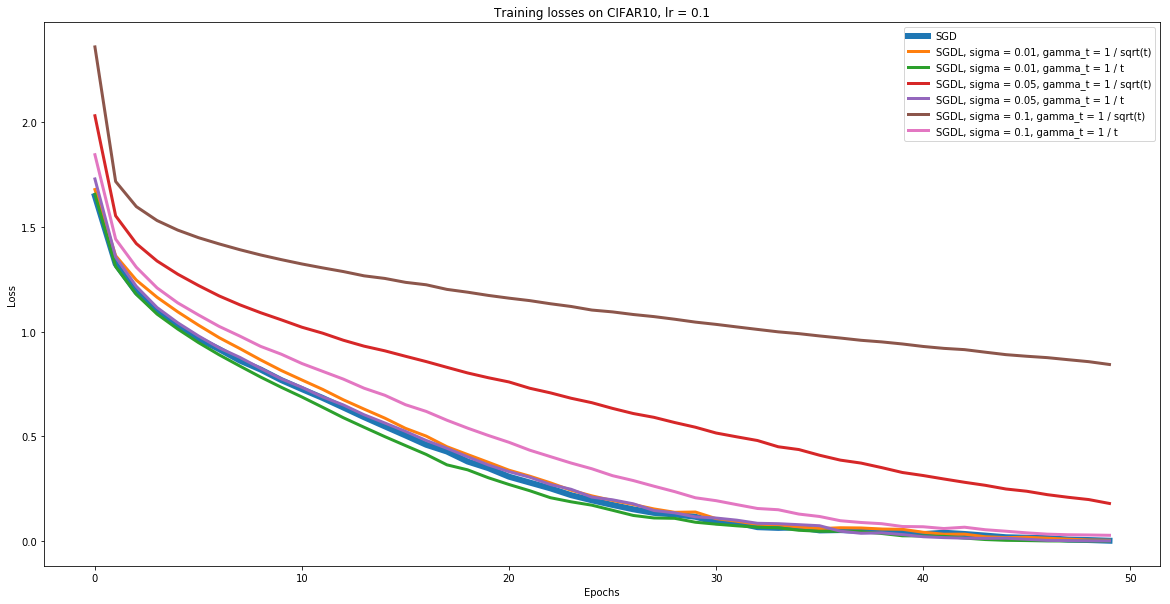

In [91]:
plt.figure(figsize=(20, 10), linewidth=5)
plt.title("Training losses on CIFAR10, lr = 0.1")
for i in range(7):
        plt.plot(list(map(lambda x: np.average(x), train_losses[i])), linewidth=6 if i == 0 else 3)
plt.legend(["SGD",
            "SGDL, sigma = 0.01, gamma_t = 1 / sqrt(t)",
            "SGDL, sigma = 0.01, gamma_t = 1 / t",
            "SGDL, sigma = 0.05, gamma_t = 1 / sqrt(t)",
            "SGDL, sigma = 0.05, gamma_t = 1 / t",
            "SGDL, sigma = 0.1, gamma_t = 1 / sqrt(t)",
            "SGDL, sigma = 0.1, gamma_t = 1 / t",
            ])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

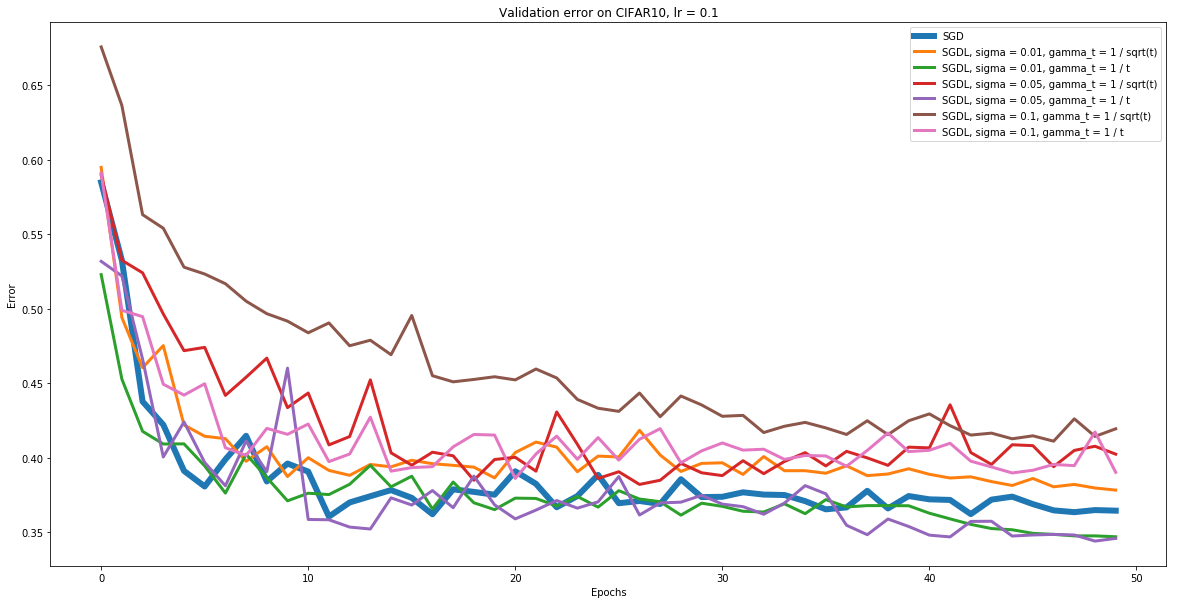

In [82]:
plt.figure(figsize=(20, 10), linewidth=5)
plt.title("Validation error on CIFAR10, lr = 0.1")
for i in range(7):
    plt.plot((100 - np.array(test_acc[i])) / 100., linewidth=6 if i == 0 else 3)
plt.legend(["SGD",
            "SGDL, sigma = 0.01, gamma_t = 1 / sqrt(t)",
            "SGDL, sigma = 0.01, gamma_t = 1 / t",
            "SGDL, sigma = 0.05, gamma_t = 1 / sqrt(t)",
            "SGDL, sigma = 0.05, gamma_t = 1 / t",
            "SGDL, sigma = 0.1, gamma_t = 1 / sqrt(t)",
            "SGDL, sigma = 0.1, gamma_t = 1 / t",
            ])
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

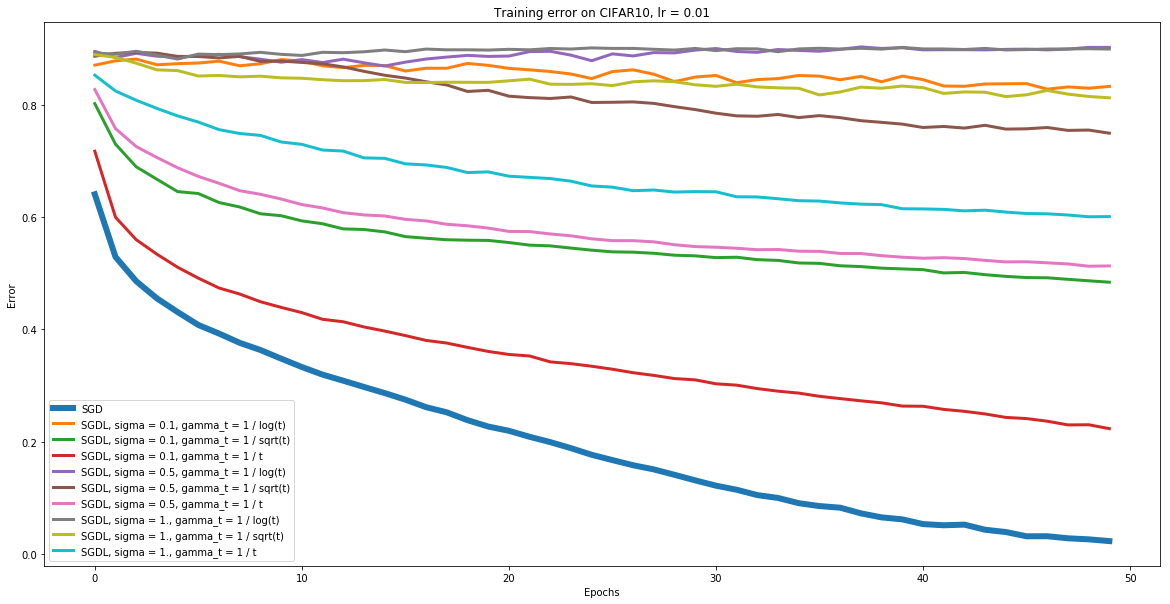

In [56]:
plt.figure(figsize=(20, 10), linewidth=5)
plt.title("Training error on CIFAR10, lr = 0.01")
for i in range(10):
    plt.plot((100 - np.array(train_acc_new[i][50:])) / 100., linewidth=6 if i == 0 else 3)
plt.legend(["SGD", 
            "SGDL, sigma = 0.1, gamma_t = 1 / log(t)",
            "SGDL, sigma = 0.1, gamma_t = 1 / sqrt(t)",
            "SGDL, sigma = 0.1, gamma_t = 1 / t",
            "SGDL, sigma = 0.5, gamma_t = 1 / log(t)",
            "SGDL, sigma = 0.5, gamma_t = 1 / sqrt(t)",
            "SGDL, sigma = 0.5, gamma_t = 1 / t",
            "SGDL, sigma = 1., gamma_t = 1 / log(t)",
            "SGDL, sigma = 1., gamma_t = 1 / sqrt(t)",
            "SGDL, sigma = 1., gamma_t = 1 / t",
            ])
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()